## Note
Before running this, make sure to empty the classify/ folder for this trial.

In [1]:
# Params for trial number and checkpoint epoch to take
TRIAL = 1
CHECKPOINT_EPOCH = 50

TRIAL_PATH = f'/content/gdrive/Shared drives/Embryo_data/pix2pix_output/{TRIAL}'
CHECKPOINT_PATH = f'{TRIAL_PATH}/checkpoints/ckpt-{CHECKPOINT_EPOCH}'
CHECKPOINT_DIR = f'{TRIAL_PATH}/checkpoints'

CLASSIFY_PATH = f'/content/gdrive/Shared drives/Embryo_data/pix2pix_output/{TRIAL}/classify'

In [2]:
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab/48919022
import os
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
# print(os.path.abspath('utils.py'))
import utils
help(utils)

Saving utils.py to utils.py
Help on module utils:

NAME
    utils

FUNCTIONS
    avg_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the average for that pixel across
        all images in the z-stack.
    
    get_img_at_t(t, img)
    
    get_max_pixel(embryos, data_path)
        Obtains the maximum pixel value across a set of embryos
        embryos: subset of p_embryo... train, val, test
        data_path: path from which to load processed np embryo data
    
    get_z_slice(z, img)
    
    max_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the maximum for that pixel across
        all images in the z-stack.
    
    middle_z(img)
    
    min_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the minimum for that pixel across
        all images in the z-stack.
    
    normalize(img)
        Normalizes pixel values across all images in i

In [3]:
import tensorflow as tf
import numpy as np

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [4]:
from google.colab import drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
home_path = '/content/gdrive/Shared drives/Embryo_data'
print(os.listdir(home_path))

Mounted at /content/gdrive
['mxnet_cnn2d_embryo_58_fine_tune_data_aug_ResNet50_v2_order_random.ipynb', 'Embryo3', 'Embryo12', 'Embryo13', 'Embryo16', 'Embryo19', 'Embryo18', 'Embryo24', 'Embryo39', 'Embryo42', 'Embryo46', 'Embryo47', 'Embryo23', 'Embryo33', 'Embryo25', 'Embryo95', 'Embryo97', 'Embryo96', 'Embryo98', 'Embryo101', 'Embryo99', 'Embryo100', 'Embryo102', 'Embryo76', 'Embryo78', 'Embryo81', 'Embryo79', 'Embryo80', 'Embryo84', 'Embryo85', 'Embryo87', 'Embryo88', 'Embryo92', 'Embryo94', 'Embryo93', 'embryo_info_CS101.xlsx', 'data', 'processed', 'models', 'pix2pix_PyTorch-GAN.ipynb', 'annotation.xlsx', 'Embryo110', 'Embryo109', 'Embryo111', 'Embryo113', 'Embryo112', 'Embryo114', 'Embryo116', 'Embryo115', 'Embryo117', 'Embryo118', 'Embryo119', 'Embryo120', 'Embryo103', 'Embryo104', 'Embryo105', 'Embryo107', 'Embryo106', 'Embryo108', 'pix2pix_output', 'images']


In [5]:
# Fixing the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Available high quality data
embryo_inds = utils.CLEAN_IDX

# Directory of the processed *.npy files
processed_path = f'{home_path}/processed'
polar_processed_path = f'{processed_path}/polarization'

video_time_info, train_embryos, val_embryos, test_embryos = utils.split_train_test_val(home_path, embryo_inds)

z_agg_mode = "Max Z"
get_data_path = lambda data_type : f'{processed_path}/{data_type}/max'
pol_path = f'{processed_path}/polarization'

              t_num  first_anno_pol_time
embryo_index                            
3                21                   12
12              143                   11
13              143                   12
16              143                   30
18              143                   27
19              143                   32
23               40                   18
24               21                   20
25               21                   13
33               21                   15
39               21                   12
42               21                   16
46               21                   19
47               21                   17
76              109                   68
78              109                   75
79              109                   68
80              109                   65
81              109                   95
85              109                  102
87              109                   62
88              109                   75
92              

In [6]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512 # 256
IMG_HEIGHT = 512 # 256

In [7]:
def load(bf_file):
  # Load the bf_file as the input image
  input_image = tf.io.read_file(bf_file)
  input_image = tf.image.decode_png(input_image)

  # Load the corresponding fluo_file as the real image
  if type(bf_file) is str:
    fluo_file = bf_file.replace("bf_data","fluo_data")
  else:
    fluo_file = tf.strings.regex_replace(bf_file, "bf_data","fluo_data")
  real_image = tf.io.read_file(fluo_file)
  real_image = tf.image.decode_png(real_image)

  # Convert both to a float32
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  # # Obtain labels for embryo-time-polarization
  # if type(bf_file) is str:
  #     file_name = bf_file.split('/')[-1]
  #     file_name = file_name.strip(".png")
  #     labels = file_name.split('_')[1:]
  #     labels = [int(l) for l in labels]
  # else:
  #     file_name = tf.strings.split(bf_file, sep="/")
  #     print(file_name.get_shape())
  #     file_name = file_name[-1]
  #     file_name = tf.strings.strip(".png")
  #     labels = tf.strings.split(file_name, sep="_")
  #     labels = labels[1:]
  #     labels = tf.strings.to_number(labels, out_type=tf.dtypes.int32)

  return input_image, real_image, bf_file

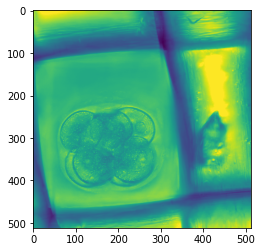

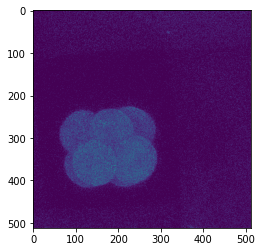

In [8]:
BF_TRAIN_PATH = f'{processed_path}/pix2pix/train/bf_data'
inp, re, _ = load(BF_TRAIN_PATH+'/embryo_3_0_0.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(tf.squeeze(inp/255.0))
plt.figure()
plt.imshow(tf.squeeze(re/255.0))

In [9]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [10]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

  return cropped_image[0], cropped_image[1]

In [11]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [12]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 1
  new_size = 286 * 2
  input_image, real_image = resize(input_image, real_image, new_size, new_size)

  # randomly cropping to 512 x 512 x 1
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  input_image, real_image, labels = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image, labels

In [14]:
BF_TEST_PATH = f'{processed_path}/pix2pix/test/bf_data'
test_dataset = tf.data.Dataset.list_files(BF_TEST_PATH+'/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
def generate_labels(file_name):
  # ordered output: idx, timestep, pol
  file_name = str(file_name.numpy()[0])
  file_name = file_name.split('/')[-1]
  file_name = file_name.strip(".png'")
  labels = file_name.split('_')[1:]
  return [int(l) for l in labels]

def generate_images(model, test_input, tar, file_name, train_test, epoch):
  '''
  train_test is 'train' or 'test' or 'classify'
  '''

  idx, t, pol = generate_labels(file_name)

  prediction = model(test_input, training=True) 

  if train_test == 'classify':
    prediction = (prediction * 0.5 + 0.5).numpy()
    plt.imsave(f'{TRIAL_PATH}/{train_test}/{pol}/embryo{idx}_t{t}_pol{pol}.png', np.squeeze(prediction))
    return

  # turn off interactive plotting
  # https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
  # https://chartio.com/resources/tutorials/how-to-save-a-plot-to-a-file-using-matplotlib/
  plt.ioff()
  fig = plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = [f'Input Image (idx {idx}, t-step {t}, pol {pol})', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(np.squeeze(display_list[i] * 0.5 + 0.5))
    plt.axis('off')
  # plt.show()

  # put epoch num first so you can order by epoch more easily
  plt.savefig(f'{TRIAL_PATH}/{train_test}/epoch{epoch}_embryo{idx}_t{t}_pol{pol}.png', bbox_inches='tight')
  plt.close(fig)

In [16]:
# restoring the latest checkpoint in checkpoint_dir
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

def Generator():
  # inputs = tf.keras.layers.Input(shape=[256,256,1])

  # down_stack = [
  #   downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
  #   downsample(128, 4), # (bs, 64, 64, 128)
  #   downsample(256, 4), # (bs, 32, 32, 256)
  #   downsample(512, 4), # (bs, 16, 16, 512)
  #   downsample(512, 4), # (bs, 8, 8, 512)
  #   downsample(512, 4), # (bs, 4, 4, 512)
  #   downsample(512, 4), # (bs, 2, 2, 512)
  #   downsample(512, 4), # (bs, 1, 1, 512)
  # ]

  # up_stack = [
  #   upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
  #   upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
  #   upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
  #   upsample(512, 4), # (bs, 16, 16, 1024)
  #   upsample(256, 4), # (bs, 32, 32, 512)
  #   upsample(128, 4), # (bs, 64, 64, 256)
  #   upsample(64, 4), # (bs, 128, 128, 128)
  # ]


  inputs = tf.keras.layers.Input(shape=[512,512,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128, 4), # (bs, 128, 128, 128)
    downsample(256, 4), # (bs, 64, 64, 256)
    downsample(512, 4), # (bs, 32, 32, 512)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(512, 4), # (bs, 32, 32, 1024)
    upsample(256, 4), # (bs, 64, 64, 512)
    upsample(128, 4), # (bs, 128, 128, 256)
    upsample(64, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  # inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  # tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')
  inp = tf.keras.layers.Input(shape=[512, 512, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  # down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  # down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  # down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  # zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  # conv = tf.keras.layers.Conv2D(512, 4, strides=1,
  #                               kernel_initializer=initializer,
  #                               use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  # batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  # leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  # zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  # last = tf.keras.layers.Conv2D(1, 4, strides=1,
  #                               kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  down1 = downsample(32, 4, False)(x) # (bs, 256, 256, 32)
  down2 = downsample(64, 4)(down1) # (bs, 128, 128, 64)
  down3 = downsample(128, 4)(down2) # (bs, 64, 64, 128)
  down4 = downsample(256, 4)(down3) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

(1, 256, 256, 3)
(1, 512, 512, 3)


In [17]:
# tf.train.checkpoints_iterator(CHECKPOINT_DIR):
checkpoint.restore(CHECKPOINT_PATH)

In [18]:
# # Run the trained model on all examples from the test dataset
# for inp, tar, name in test_dataset.take(len(test_dataset)):
#   generate_images(generator, inp, tar, name, 'classify', CHECKPOINT_EPOCH)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

print("Pytorch version: ", torch.__version__)

Pytorch version:  1.7.0+cu101


In [20]:
import pandas as pd
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
classes = 2

epochs = 15
lr = 0.001
per_device_batch_size = 20
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_workers = 1
num_gpus = 1
gpus = [i for i in range(num_gpus)]

device = torch.device(gpus[0]) if num_gpus > 0 else [torch.device('cpu')]

batch_size = per_device_batch_size * max(num_gpus, 1)
print(device)

cuda:0


In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [23]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

test_data = torchvision.datasets.ImageFolder(root=CLASSIFY_PATH, transform=transform, target_transform=None, is_valid_file=check_image)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, sampler=None, num_workers=num_workers, drop_last=True)
classes = ('unpolarized', 'polarized')

In [24]:
# Step 3: define the PyTorch architecture to load in the weights

class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # # self.dropout = nn.Dropout(p=0.2)
        # self.batchnorm1 = nn.BatchNorm2d(20)
        # self.batchnorm2 = nn.BatchNorm2d(50)
        
        # cf comments in forward() to have step by step comments on shape progression
        # self.fc1 = nn.Linear(256 * 64 * 64, 64)
        self.fc1 = nn.Linear(100 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 512, 512)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # print(x.shape)

        # shape : 3x512x512 -> 20x512x512
        x = F.dropout(F.relu(self.conv1(x)), p=0.2, training=True)
        # x = self.batchnorm1(F.relu(self.conv1(x)))

        # x = F.relu(self.conv1(x))
        # print(x.shape)

        # 20x512x512 -> 20x256x256
        x = self.pool1(x)
        # print(x.shape)

        # 20x256x256 -> 50x256x256
        x = F.dropout(F.relu(self.conv2(x)), p=0.2, training=True)
        # x = self.batchnorm2(F.relu(self.conv2(x)))
        # x = F.relu(self.conv2(x))
        # print(x.shape)

        # 50x256x256 -> 50x128x128
        x = self.pool2(x)
        # print(x.shape)

        # 50x128x128 -> 100x128x128
        x = F.dropout(F.relu(self.conv3(x)), p=0.2, training=True)
        # print(x.shape)

        # 100x128x128 -> 100x64x64
        x = self.pool3(x)
        # print(x.shape)

        # 100x64x64 -> .
        x = x.view(-1, 100 * 64 *64)
        # print(x.shape)

        # . -> 64
        x = F.relu(self.fc1(x))
        # print(x.shape)

        # 64 -> 2
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        # print(x.shape)

        return x

In [25]:
# Step 4: instantiate the architecture with saved params

network = SimpleConvolutionalNetwork()
network = network.to(device)
name = 'torchCNN-max-windowNone-windowNone-batch20-lr0.0001-mom0.9-epoch2'
network.load_state_dict(torch.load(f'/content/gdrive/Shared drives/Embryo_data/models/best/{name}.pth'))

<All keys matched successfully>

In [26]:
network.eval()

SimpleConvolutionalNetwork(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=409600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [30]:
def dataset_accuracy(net, data_loader, name="", print_first_k_mistakes=0):
    net = net.to(device)
    correct = 0
    total = 0
    to_print = []
    for images_loader, labels_loader in data_loader:
        images, labels = images_loader.to(device), labels_loader.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        if print_first_k_mistakes > 0:
            for idx, match in enumerate(zip(predicted, labels)):
                if match[0] != match[1]:
                    error = "Actually unpolarized:"
                    if match[1] == 1:
                        error = "Actually polarized:"
                    to_print.append((error, images_loader[idx]))
                    print_first_k_mistakes -= 1
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

    if len(to_print) > 0:
        print('\n'.join('{:>10}'.format(label[0]) for label in to_print))
        imshow(torchvision.utils.make_grid([img[1] for img in to_print]))

In [31]:
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test", 10)

In [32]:
# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    plt.figure(figsize = (20,8))
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


Accuracy of the network on the 440 test images: 72.27 %
Actually polarized:
Actually polarized:
Actually polarized:
Actually polarized:
Actually polarized:
Actually polarized:
Actually polarized:
Actually polarized:
Actually polarized:
Actually polarized:


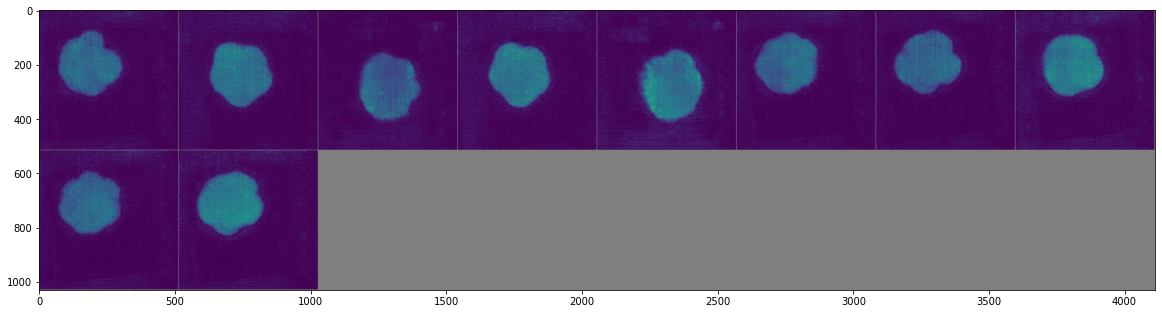

In [33]:
test_set_accuracy(network)

In [34]:
import itertools

test_batch_size = batch_size

def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 2
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

In [35]:
confusion_matrix = accuracy_per_class(network)

Class      Accuracy (%)
unpolarized   100.00  
polarized     0.00   
